# Training and Validation Set Generator

## Imports

In [1]:
# Math and Plotting
import numpy as np                         
import matplotlib.pyplot as plt             
from pyscenarios.sobol import sobol  
from scipy import constants, interpolate
%matplotlib inline
import itertools
import math
import torch

# Basic Data Imports
import time
from pickle import dump, load 
import pandas as pd

# RDF Analysis and Simulations
from utility.hoomd_sim import neon
from utility.rdf_analysis import rdf2sq
from utility.rdf_analysis import compute_simple_rdf

# Parallel Computing
import dask
from dask.distributed import Client, progress
from matplotlib.pyplot import figure
from dask import config as cfg
import os
os.environ["OMP_NUM_THREADS"] = "1" 

## Experimental Observables

Old length:  155
New length:  73


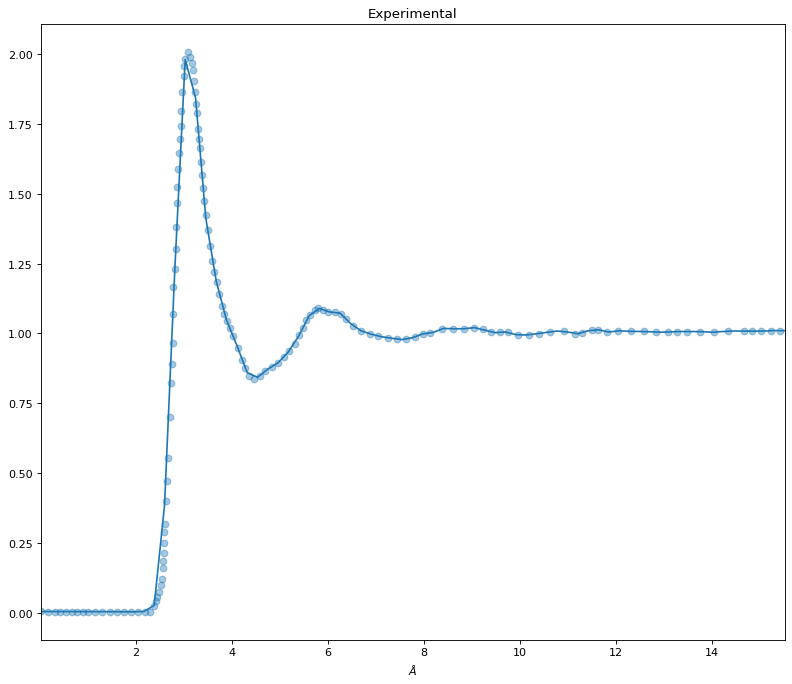

In [2]:
experimentalCSVFilename = 'exp_data/ne_42K_rdf.csv'

data = pd.read_csv(experimentalCSVFilename)
r_exp_raw = np.array(data['r'])
rdf_exp_raw = np.array(data[' g'])

rmin = 0.0118331810091873
rmax = 15.512161254882812
rnum = 73

# Interpolalate the experimental data to make it consistent with the simulations
r  = torch.tensor(np.linspace(rmin, rmax, num=rnum))
rdf_exp_i = interpolate.splrep(r_exp_raw, rdf_exp_raw, s=0)
rdf_exp = torch.from_numpy(interpolate.splev(r, rdf_exp_i, der=0))

print("Old length: ", len(r_exp_raw))
print("New length: ", len(r))

plt.figure(figsize = (12,10),dpi=80)
plt.title("Experimental")
plt.scatter(r_exp_raw,rdf_exp_raw,alpha=0.4)
plt.plot(r, rdf_exp)
plt.xlim(rmin,rmax)
plt.xlabel("$\AA$")
plt.show()

## Initial GP Training Set Input Space

In [3]:
ndims  = 3          # number of model parameters
nsims  = 320        # number of training simulations
niters = 3          # number of shrinking steps
ratio  = 0.8        # how much to shrink the space after each iteration (iteration i+1 will be ratio*100 percent of iteration i)

nmax = 18
σmax = 3.32
ϵmax = 0.1357

nmin = 6.1
σmin = 2.55
ϵmin = 0.0001

nrange = nmax-nmin
σrange = σmax-σmin
ϵrange = ϵmax-ϵmin

# This defines the centerpoint of the optimization
center_point = [(nmin + nmax)/2, (σmin + σmax)/2, (ϵmin + ϵmax)/2]

for iter in range(niters):
    ranges = torch.tensor([[center_point[0]-(nrange*(ratio)**iter)/2,center_point[0] + (nrange*(ratio)**iter)/2],
                           [center_point[1]-(σrange*(ratio)**iter)/2,center_point[1] + (σrange*(ratio)**iter)/2],
                           [center_point[2]-(ϵrange*(ratio)**iter)/2,center_point[2] + (ϵrange*(ratio)**iter)/2]])
print("The ranges chosen imply that you expect the posterior to have probability near zero this far from the map plus or minus:")
names = ["n","σ","ϵ"]
for i in range(niters):
    print(names[i] + ":", (ranges[i][1] - ranges[i][0]).item()/2)

The ranges chosen imply that you expect the posterior to have probability near zero this far from the map plus or minus:
n: 3.808000087738037
σ: 0.24639999866485596
ϵ: 0.04339199885725975


In [4]:
path_parent = "training_data"
N_particles = 864
spacing = 6
name = 'Ne'
timestep = 0.005
k   = 3.29982916e-27 #boltzmann constant,   [kcal/K/particle]   
av  = 6.0223e23      #avagadro number,      [particle/mol]  
T   = 42.2           #temperature,          [K]
kbT = k * av * T
density = 0.02477
eq_time = 50_000
production_time = 3e5
stride = 1000

## Generate Training Dataset

In [5]:
try:

    print("Attempting to Load Previously Computed Data")
    
    input_dict = load(open('training_data/xs.p', 'rb'))
    xs = input_dict['xs']

    input_dict = load(open('training_data/iter_0/rdfs.p', 'rb'))
    r      = input_dict['r']
    rdfs_0 = input_dict['rdfs']

    input_dict = load(open('training_data/iter_1/rdfs.p', 'rb'))
    rdfs_1 = input_dict['rdfs']

    input_dict = load(open('training_data/iter_2/rdfs.p', 'rb'))
    rdfs_2 = input_dict['rdfs']

    rdfs = torch.zeros((niters,nsims,rnum))
    for i in range(len(rdfs_0)):
        rdfs[0][i]=rdfs_0[i]
        
    for i in range(len(rdfs_0)):
        rdfs[1][i]=rdfs_1[i]
    
    for i in range(len(rdfs_0)):
        rdfs[2][i]=rdfs_2[i]

    print("Success!")
    
except:

    print("Failed, Running Simulations")
    
    xs = torch.zeros(niters,nsims,ndims)

    cfg.set({'distributed.scheduler.worker-ttl': None}) # This stops dask from crying when the sims take a long time.
    client = Client(threads_per_worker=1, n_workers=40)
    
    for iter in range(niters):

        path = path_parent + "/iter_"+str(iter)
    
        print("Starting iteration",iter)
    
        ### GENERATE XS RANGES ###

        ranges = torch.tensor([[center_point[0]-(nrange*(ratio)**iter)/2,center_point[0] + (nrange*(ratio)**iter)/2],
                               [center_point[1]-(σrange*(ratio)**iter)/2,center_point[1] + (σrange*(ratio)**iter)/2],
                               [center_point[2]-(ϵrange*(ratio)**iter)/2,center_point[2] + (ϵrange*(ratio)**iter)/2]])

        # Shift Range Up if Too Low
        
        if center_point[2]-(ϵrange*(ratio)**iter)/2 < ϵmin:
            ranges[2][0] = ϵmin
            ranges[2][1] = (ϵrange*(ratio)**iter) + ϵmin

        if center_point[1]-(σrange*(ratio)**iter)/2 < σmin:
            ranges[1][0] = σmin
            ranges[1][1] = (σrange*(ratio)**iter) + σmin
        
        if center_point[0]-(nrange*(ratio)**iter)/2 < nmin:
            ranges[0][0] = nmin
            ranges[0][1] = (nrange*(ratio)**iter) + nmin

        # Shift Range Down if Too High

        if center_point[2]+(ϵrange*(ratio)**iter)/2 > ϵmax:
            ranges[2][0] = ϵmax - (ϵrange*(ratio)**iter)
            ranges[2][1] = ϵmax

        if center_point[1]+(σrange*(ratio)**iter)/2 > σmax:
            ranges[1][0] = σmax - (σrange*(ratio)**iter)
            ranges[1][1] = σmax
        
        if center_point[0]+(nrange*(ratio)**iter)/2 > nmax:
            ranges[0][0] = nmax - (nrange*(ratio)**iter)
            ranges[0][1] = nmax
        
        # Generate samples of the correct dimensions
        xs[iter] = torch.tensor(sobol((nsims, ndims)))
        xs[iter] = ranges[:, 0] + xs[iter] * (ranges[:, 1] - ranges[:, 0])
    
        fig, axs = plt.subplots(1, 3, figsize=(16, 4))
        for sub_iter in range(iter+1):
            # Visualization
            axs[0].scatter(xs[sub_iter][:, 0], xs[sub_iter][:, 1])
            axs[0].set_xlabel('n')
            axs[0].set_ylabel('σ')
            axs[1].scatter(xs[sub_iter][:, 0], xs[sub_iter][:, 2])
            axs[1].set_xlabel('n')
            axs[1].set_ylabel('ϵ')
            axs[2].scatter(xs[sub_iter][:, 1], xs[sub_iter][:, 2])
            axs[2].set_xlabel('σ')
            axs[2].set_ylabel('ϵ')
        plt.savefig(path_parent+"/XS_" + str(iter))
        plt.show()

        output_dict = dict(xs = xs[iter])
        dump(output_dict, open(path+'/xs.p', 'wb'))
    
        ### RUN THE SIMULATIONS ###
    
        # Queue up function calls into dask
        lazy_results = []
        for sim in range(nsims):
            lazy_results.append(dask.delayed(neon)(
                path, sim, N_particles, spacing, name, timestep, xs[iter][sim][0].item(), xs[iter][sim][1].item(), xs[iter][sim][2].item(), kbT, density, eq_time, production_time, stride))
    
        # Split the dask calls to run 5 sets of 40 sims
        t1 = time.time()
        totalResults = []
        i = 0
        while i < nsims:
            
            # Allow dask to parallelize the set of simulations and run them
            results = dask.compute(*lazy_results[i:(i+40)])
            totalResults.append(results)
            i += 40        
    
        t2 = time.time()
        totalTime = (t2-t1)
        
        output_dict = dict(sim_time = totalResults, totalTime = totalTime)
        dump(output_dict, open(path+'/simulation_time.p', 'wb'))
    
        print("Simulations Complete!")
    
        ### COMPUTE THE RDFs ###
        lazy_results = []
        for sim in range(nsims):
            gsd_fname = path+'/traj/mie' + str(sim) +'.gsd'
            lazy_results.append(dask.delayed(compute_simple_rdf)(gsd_fname, rmin, rmax, rnum))
    
        # Split the dask calls to run 5 sets of 40 rdf calcuations
        totalResults = []
        i = 0
        while i < nsims:
            
            # Allow dask to parallelize the set of simulations and run them
            results = dask.compute(*lazy_results[i:(i+40)])
            totalResults.append(results)
            i += 40        
    
        rdfs = torch.zeros((nsims,rnum))
        k = 0
        for i in range(len(totalResults)):
            for j in range(len(totalResults[0])):
                rdfs[k] = torch.tensor(totalResults[i][j][1])
                k+=1
            i += len(totalResults[0])
    
        plt.plot(totalResults[0][0][0],rdfs.T)
        plt.savefig(path_parent+"/All_RDF_" + str(iter))
        plt.show()
    
        output_dict = dict(r = totalResults[0][0][0], rdfs = rdfs)
        dump(output_dict, open(path+'/rdfs.p', 'wb'))
        
        print("RDFs Computed!")
    
        ### RECENTER THE SPACE ###
        
        min_error = 1e100
        min_error_index = 0
        
        # Interpolalate the experimental data to make it consistent with the simulations
        r  = totalResults[0][0][0] 
        rdf_exp = torch.from_numpy(interpolate.splev(r, rdf_exp_i, der=0))
    
        for sim in range(nsims):
            if torch.sum((rdfs[sim] - rdf_exp)**2) < min_error:
                center_point = xs[iter][sim].tolist()
                min_error = torch.sum((rdfs[sim] - rdf_exp)**2)
                min_error_index = sim
    
        print("New Center Point is:",center_point)
    
        plt.plot(r,rdfs[min_error_index],label="Minmum Error RDF:" + str(center_point))
        plt.plot(r,rdf_exp,label="Experimental RDF")
        plt.legend()
        plt.savefig(path_parent+"/Best_RDF_" + str(iter))
        plt.show()
     
    output_dict = dict(xs = xs)
    dump(output_dict, open(path_parent+'/xs.p', 'wb'))

Attempting to Load Previously Computed Data
Success!


In [6]:
input_dict = load(open('training_data/rdfs.p', 'rb'))
rtraincheck = input_dict['r']
rtraincheck

array([ 0.11799981,  0.33033308,  0.54266632,  0.75499964,  0.96733284,
        1.17966604,  1.39199948,  1.60433269,  1.81666589,  2.02899909,
        2.24133253,  2.45366573,  2.66599894,  2.87833214,  3.09066558,
        3.30299878,  3.51533198,  3.72766519,  3.93999839,  4.15233135,
        4.36466503,  4.57699871,  4.78933144,  5.00166512,  5.21399784,
        5.42633152,  5.63866425,  5.85099792,  6.0633316 ,  6.27566433,
        6.48799801,  6.70033073,  6.91266441,  7.12499714,  7.33733082,
        7.54966354,  7.76199722,  7.97433043,  8.18666363,  8.39899635,
        8.61133003,  8.82366371,  9.03599739,  9.24833012,  9.46066284,
        9.67299652,  9.8853302 , 10.09766293, 10.3099966 , 10.52232933,
       10.73466301, 10.94699669, 11.15932941, 11.37166214, 11.58399582,
       11.7963295 , 12.00866318, 12.2209959 , 12.43332863, 12.64566231,
       12.85799599, 13.07032871, 13.28266144, 13.49499512, 13.7073288 ,
       13.91966248, 14.1319952 , 14.34432793, 14.55666161, 14.76

## Generate Validation Set

In [7]:
try:

    print("Attempting to Load Previously Computed Data")
    
    input_dict = load(open('testing_data/xs_test.p', 'rb'))
    xs_test = input_dict['xs_test']

    input_dict = load(open('testing_data/rdfs_test.p', 'rb'))
    rdfs_test = input_dict['rdfs']
    
    print("Success!")
except:

    nsims = 320

    cfg.set({'distributed.scheduler.worker-ttl': None}) # This stops dask from crying when the sims take a long time.
    client = Client(threads_per_worker=1, n_workers=40)
    
    print("Failed, Running simulations..")
    
    path_parent = "testing_data"
    
    nmax = max(xs[-1].T[0]).item()
    σmax = max(xs[-1].T[1]).item()
    ϵmax = max(xs[-1].T[2]).item()
    
    nmin = min(xs[-1].T[0]).item()
    σmin = min(xs[-1].T[1]).item()
    ϵmin = min(xs[-1].T[2]).item()
    
    ratio = 0.85 # How much to shrink the final range to uniformly sample the validation set over
    
    δn = (nmax - nmin)*(1-ratio)/2
    δσ = (σmax - σmin)*(1-ratio)/2
    δϵ = (ϵmax - ϵmin)*(1-ratio)/2
    
    nmax -= δn
    nmin += δn
    
    σmax -= δσ
    σmin += δσ
    
    ϵmax -= δϵ
    ϵmin += δϵ
    
    ranges = torch.tensor([[nmin,nmax],
                           [σmin,σmax],
                           [ϵmin,ϵmax]])
    
    # Generate samples of the correct dimensions
    xs_test = torch.tensor(np.random.uniform(size=(nsims, ndims)))
    xs_test = ranges[:, 0] + xs_test * (ranges[:, 1] - ranges[:, 0])
    
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
    for sub_iter in range(3):
        # Visualization
        axs[0].scatter(xs[sub_iter][:, 0], xs[sub_iter][:, 1])
        axs[0].set_xlabel('n')
        axs[0].set_ylabel('σ')
        axs[1].scatter(xs[sub_iter][:, 0], xs[sub_iter][:, 2])
        axs[1].set_xlabel('n')
        axs[1].set_ylabel('ϵ')
        axs[2].scatter(xs[sub_iter][:, 1], xs[sub_iter][:, 2])
        axs[2].set_xlabel('σ')
        axs[2].set_ylabel('ϵ')
    axs[0].scatter(xs_test[:, 0], xs_test[:, 1],label="Test")
    axs[0].set_xlabel('n')
    axs[0].set_ylabel('σ')
    axs[1].scatter(xs_test[:, 0], xs_test[:, 2],label="Test")
    axs[1].set_xlabel('n')
    axs[1].set_ylabel('ϵ')
    axs[2].scatter(xs_test[:, 1], xs_test[:, 2],label="Test")
    axs[2].set_xlabel('σ')
    axs[2].set_ylabel('ϵ')
    axs[1].legend()
    plt.savefig(path_parent+"/XS_Test")
    plt.show()
    
    ### RUN THE SIMULATIONs ###
            
    path = path_parent

    # Queue up function calls into dask
    lazy_results = []
    for sim in range(nsims):
        lazy_results.append(dask.delayed(neon)(
            path, sim, N_particles, spacing, name, timestep, xs_test[sim][0].item(), xs_test[sim][1].item(), xs_test[sim][2].item(), kbT, density, eq_time, production_time, stride))

    # Split the dask calls to run 5 sets of 40 sims
    t1 = time.time()
    totalResults = []
    i = 0
    while i < nsims:
        
        # Allow dask to parallelize the set of simulations and run them
        results = dask.compute(*lazy_results[i:(i+40)])
        totalResults.append(results)
        i += 40        

    t2 = time.time()
    totalTime = (t2-t1)

    output_dict = dict(sim_time = totalResults, totalTime = totalTime)
    dump(output_dict, open(path+'/simulation_time.p', 'wb'))

    print("Simulations Complete!")
    
    ### COMPUTE THE RDFs ###
    lazy_results = []
    for sim in range(nsims):
        gsd_fname = path+'/traj/mie' + str(sim) +'.gsd'
        lazy_results.append(dask.delayed(compute_simple_rdf)(gsd_fname, rmin, rmax, rnum))

    # Split the dask calls to run 5 sets of 40 rdf calcuations
    totalResults = []
    i = 0
    while i < nsims:
        
        # Allow dask to parallelize the set of simulations and run them
        results = dask.compute(*lazy_results[i:(i+40)])
        totalResults.append(results)
        i += 40        

    rdfs = torch.zeros((nsims,rnum))
    k = 0
    for i in range(len(totalResults)):
        for j in range(len(totalResults[0])):
            rdfs[k] = torch.tensor(totalResults[i][j][1])
            k+=1
        i += len(totalResults[0])

    plt.plot(totalResults[0][0][0],rdfs.T)
    plt.savefig(path_parent+"/All_RDF_Test")
    plt.show()

    output_dict = dict(r = totalResults[0][0][0], rdfs = rdfs)
    dump(output_dict, open(path+'/rdfs_test.p', 'wb'))
    
    print("RDFs Computed!")

    output_dict = dict(xs_test = xs_test)
    dump(output_dict, open(path_parent+'/xs_test.p', 'wb'))

Attempting to Load Previously Computed Data
Success!


In [16]:
input_dict = load(open('training_data/iter_0/simulation_time.p', 'rb'))
time1 = input_dict['sim_time']
input_dict = load(open('training_data/iter_1/simulation_time.p', 'rb'))
time2 = input_dict['sim_time']
input_dict = load(open('training_data/iter_2/simulation_time.p', 'rb'))
time3 = input_dict['sim_time']

In [22]:
average_time = (np.mean(time1) + np.mean(time2) + np.mean(time3)) / 3
average_time

1251.0926679519316